In [1]:
import pennylane as qml
import torch
import pennylane.numpy as np
import matplotlib.pyplot as plt
import cirq
from keras.datasets import fashion_mnist
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import OneHotEncoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
# Data preprocessing with Fashion MNIST. Limit to four classes.

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Filter out only the first four labels (0, 1, 2, 3)
train_filter = np.isin(y_train, [0, 1, 2, 3])
test_filter = np.isin(y_test, [0, 1, 2, 3])

# Limiting data size due to high training times
data_size = 1000

x_train, y_train = x_train[train_filter][:data_size], y_train[train_filter][:data_size]
x_test, y_test = x_test[test_filter][:data_size], y_test[test_filter][:data_size]

# Resize the images to 16x16 pixels for use in 8-qubit circuit
x_train_resized = np.array([resize(image, (16, 16), mode='reflect', anti_aliasing=True) for image in x_train])      # resize
x_test_resized = np.array([resize(image, (16, 16), mode='reflect', anti_aliasing=True) for image in x_test])


x_train_flat = x_train_resized.reshape(-1, 16*16)
x_test_flat = x_test_resized.reshape(-1, 16*16)

# Scaling
x_train_scaled = x_train_flat / 255.0
x_test_scaled = x_test_flat / 255.0

Initialisation of trainable circuit parameters and feature resizing for amplituding embedding.

Values in theta and phi tensor name (_value) correspond to the size of the filter that the parameters are applied to.

In [17]:

features = x_train_resized[0].flatten()
torch.manual_seed(0)

# Parameters initialization directly as PyTorch tensors
theta_4 = torch.rand((4, 1), dtype=torch.float32, requires_grad=True)
phi_4 = torch.rand((4, 1), dtype=torch.float32, requires_grad=True)
theta_2 = torch.rand((4, 1), dtype=torch.float32, requires_grad=True)
pool_1 = torch.rand((2, 1), dtype=torch.float32, requires_grad=True)
pool_2 = torch.rand((2, 1), dtype=torch.float32, requires_grad=True)
final_filter = torch.rand((4, 1), dtype=torch.float32, requires_grad=True)

# Initialize regular layer weights as tensors
Reg_y1_weights = torch.rand((12, 1), dtype=torch.float32, requires_grad=True)
Reg_x1_weights = torch.rand((12, 1), dtype=torch.float32, requires_grad=True)
Reg_z1_weights = torch.rand((12, 1), dtype=torch.float32, requires_grad=True)

# Create a list of all parameters that require optimization
params = [
    theta_4, phi_4, theta_2, pool_1, pool_2, final_filter, Reg_y1_weights, Reg_x1_weights, Reg_z1_weights
]

The following is a reimplementation of the circuit from https://doi.org/10.3389/fphy.2022.1069985. This implementation does not use the 3-qubit filtering mentioned in the original paper due to ambiguity regarding the use of parameters in these filters and only uses 3 "regular" layers due to possible barren plateaus impacting gradient optimisation.

c:\Python312\Lib\site-packages\pennylane_lightning\lightning_qubit\lightning_qubit.py:898: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(
c:\Python312\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 6200x900 with 1 Axes>, <Axes: >)
Probability of state |00000000>: 0.249373
Probability of state |00000001>: 0.167258
Probability of state |00000010>: 0.360461
Probability of state |00000011>: 0.222909
Total probability: 1.000001	 Highest Probability: 00000010


c:\Python312\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


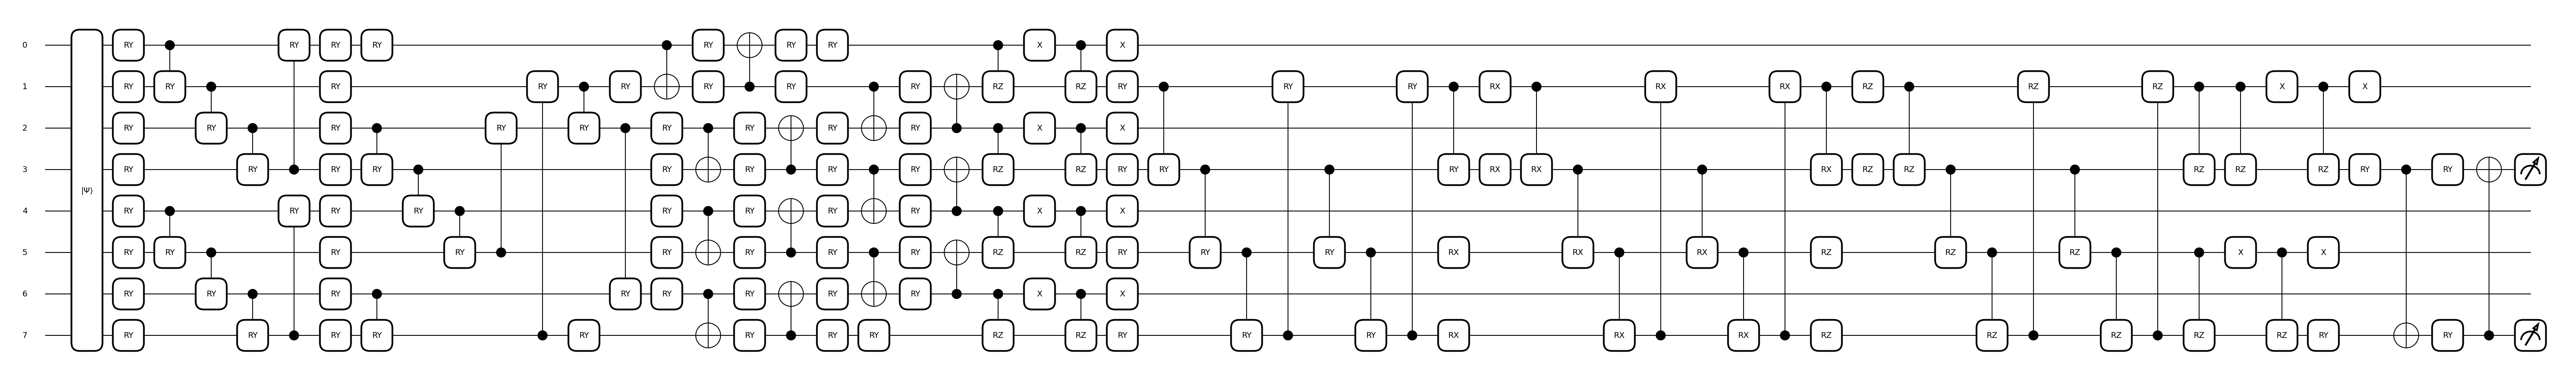

In [5]:
# 8 wires for operations
n_wires = 8
dev = qml.device("lightning.qubit", wires=n_wires)

# Just a list of pairs of wires that some controlled rotations are applied to. Simplifies some parts of the code.
pairs = [[2, 3],[3, 4],[4, 5], [5, 2], [6, 7], [7, 1], [1, 2], [2, 6]]

@qml.qnode(dev, interface='torch')
def circuit(features, theta_4, phi_4, theta_2, pool_1, pool_2, final_filter, Reg_y1_weights, Reg_x1_weights, Reg_z1_weights):

    # Using amplitude embedding as mentioned in the original paper
    qml.AmplitudeEmbedding(features=features, wires=range(8), normalize=True)

    # 4 qubit filtering
    for i in range(n_wires):
        qml.RY(theta_4[i%4], wires=i)
    
    # Apply CRY gates in a controlled manner for the first block (0-3) with wrap-around
    for i in range(4):
        qml.CRY(phi_4[i], wires=[i, (i + 1) % 4])

    for i in range(4, n_wires-1):
        qml.CRY(phi_4[i%4], wires=[i, i+1])
    qml.CRY(phi_4[3], wires=[7, 4])

    # Assuming the 4 bit filter wraps around. The paper is unclear here, there may be 2 2-qubit filters instead
    idx = 2
    for i in range(n_wires):
        qml.RY(theta_4[idx], wires=i)
        idx = (idx+1)%4
    
    for i in range(n_wires):
        qml.CRY(theta_4[i%4], pairs[i])

    # 2 qubit filtering
    for i in range(0, n_wires, 2):
        qml.RY(theta_2[0], wires=i)
        qml.RY(theta_2[1], wires=i+1)
        qml.CNOT(wires=[i, i+1])
        qml.RY(theta_2[2], wires=i)
        qml.RY(theta_2[3], wires=i+1)
        qml.CNOT(wires=[i+1,i])

    # edges have virtual qubits, will have to add these later. For now, just rotate on edges alone
    qml.RY(theta_2[1], wires=0)
    qml.RY(theta_2[2], wires=0)

    for i in range(1, 7, 2):
        qml.RY(theta_2[0], wires=i)
        qml.RY(theta_2[1], wires=i+1)
        qml.CNOT(wires=[i, i+1])
        qml.RY(theta_2[2], wires=i)
        qml.RY(theta_2[3], wires=i+1)
        qml.CNOT(wires=[i+1,i])

    qml.RY(theta_2[0], wires=7)
    qml.RY(theta_2[2], wires=7)

    # Pooling
    for i in range(0, n_wires, 2):
        qml.CRZ(pool_1[0], wires=[i, i+1])
        qml.X(wires=i)
        qml.CRZ(pool_1[1], wires=[i, i+1])
        qml.X(wires=i)

    # From here on, only every second wire is used
    
    # Regular layers
    qml.RY(Reg_y1_weights[0], wires=1)
    qml.RY(Reg_y1_weights[1], wires=3)
    qml.RY(Reg_y1_weights[2], wires=5)
    qml.RY(Reg_y1_weights[3], wires=7)
    qml.CRY(Reg_y1_weights[4], wires=[1, 3])
    qml.CRY(Reg_y1_weights[5], wires=[3, 5])
    qml.CRY(Reg_y1_weights[6], wires=[5, 7])
    qml.CRY(Reg_y1_weights[7], wires=[7, 1])
    qml.CRY(Reg_y1_weights[8], wires=[3, 5])
    qml.CRY(Reg_y1_weights[9], wires=[5, 7])
    qml.CRY(Reg_y1_weights[10], wires=[7, 1])
    qml.CRY(Reg_y1_weights[11], wires=[1, 3])

    qml.RX(Reg_x1_weights[0], wires=1)
    qml.RX(Reg_x1_weights[1], wires=3)
    qml.RX(Reg_x1_weights[2], wires=5)
    qml.RX(Reg_x1_weights[3], wires=7)
    qml.CRX(Reg_x1_weights[4], wires=[1, 3])
    qml.CRX(Reg_x1_weights[5], wires=[3, 5])
    qml.CRX(Reg_x1_weights[6], wires=[5, 7])
    qml.CRX(Reg_x1_weights[7], wires=[7, 1])
    qml.CRX(Reg_x1_weights[8], wires=[3, 5])
    qml.CRX(Reg_x1_weights[9], wires=[5, 7])
    qml.CRX(Reg_x1_weights[10], wires=[7, 1])
    qml.CRX(Reg_x1_weights[11], wires=[1, 3])


    qml.RZ(Reg_z1_weights[0], wires=1)
    qml.RZ(Reg_z1_weights[1], wires=3)
    qml.RZ(Reg_z1_weights[2], wires=5)
    qml.RZ(Reg_z1_weights[3], wires=7)
    qml.CRZ(Reg_z1_weights[4], wires=[1, 3])
    qml.CRZ(Reg_z1_weights[5], wires=[3, 5])
    qml.CRZ(Reg_z1_weights[6], wires=[5, 7])
    qml.CRZ(Reg_z1_weights[7], wires=[7, 1])
    qml.CRZ(Reg_z1_weights[8], wires=[3, 5])
    qml.CRZ(Reg_z1_weights[9], wires=[5, 7])
    qml.CRZ(Reg_z1_weights[10], wires=[7, 1])
    qml.CRZ(Reg_z1_weights[11], wires=[1, 3])

    # Second Pooling
    qml.CRZ(pool_2[0], wires=[1, 3])
    qml.X(wires=1)
    qml.CRZ(pool_2[1], wires=[1, 3])
    qml.X(wires=1)

    qml.CRZ(pool_2[0], wires=[5, 7])
    qml.X(wires=5)
    qml.CRZ(pool_2[1], wires=[5, 7])
    qml.X(wires=5)

    # Only using wires 3 and 7 now
    # Final filter
    qml.RY(final_filter[0], wires=3)
    qml.RY(final_filter[1], wires=7)
    qml.CNOT(wires=[3, 7])
    qml.RY(final_filter[2], wires=3)
    qml.RY(final_filter[3], wires=7)
    qml.CNOT(wires=[7, 3])


    return qml.probs(wires=[3, 7])



print(qml.draw_mpl(circuit, decimals=2)(features, *params))

# Execute the circuit
state_vector = circuit(features, *params)
probabilities = state_vector.detach().numpy()

# Format the output for better readability
formatted_probabilities = {format(i, '08b'): prob for i, prob in enumerate(probabilities.flatten())}

# Initialize sum and tracking variables for highest probability
prob_sum = 0.0
highest = (0.0, '')
all_probs = torch.zeros(4, dtype=torch.float32)  # Adjust size as needed based on your circuit's output
i = 0  # Initialize index for filling all_probs

# Print and analyze the probabilities
for state, prob in formatted_probabilities.items():
    print(f"Probability of state |{state}>: {prob:.6f}")
    prob_sum += prob
    if prob > highest[0]:
        highest = (prob, state)
    if i < len(all_probs):
        all_probs[i] = float(prob)  # Convert to Python float for compatibility with PyTorch
        i += 1  # Increment index after storing the probability

print(f'Total probability: {prob_sum:.6f}\t Highest Probability: {highest[1]}')

In [18]:
# Hyperparamters

n_epochs = 20
learning_rate = 0.00005
loss_function = torch.nn.CrossEntropyLoss()
optimizer = Adam(params, lr=learning_rate)

# Making features and targets PyTorch compatible
features_train = [torch.tensor(f.flatten(), dtype=torch.float32) for f in x_train_scaled]  # Flatten and convert data
targets_train = torch.tensor(y_train, dtype=torch.long)  # Ensure target labels are in long format for classification


In [19]:
# Simple SGD

def train(circuit, features, targets, epochs):
    loss_history = np.zeros(epochs)  # To store loss values
    accuracy_history = np.zeros(epochs)  # To store accuracy values

    for epoch in range(epochs):
        total_loss = 0
        correct_count = 0  # To count correctly predicted instances

        for x, y in zip(features, targets):
            optimizer.zero_grad()  # Clear gradients from the previous step

            # Forward pass: compute the predicted probabilities by passing x to the model
            predicted_probs = circuit(x, *params)
            predicted_probs = F.softmax(predicted_probs, dim=1)  # Apply softmax to the output of the circuit

            # Compute and print loss
            loss = loss_function(predicted_probs, y.unsqueeze(0))  # Make sure y is correctly shaped for loss calculation
            total_loss += loss.item()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Update parameters
            optimizer.step()

            # Determine the predicted class and compare with the true label
            predicted_label = predicted_probs.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct_count += (predicted_label.flatten() == y).sum().item()

        # Store the average loss and accuracy for this epoch
        average_loss = total_loss / len(features)
        accuracy = correct_count / len(features)

        loss_history[epoch] = average_loss
        accuracy_history[epoch] = accuracy

        print(f"Epoch {epoch}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

    return loss_history, accuracy_history


In [20]:
# Run the training loop
loss_history, accuracy_history = train(circuit, features_train, targets_train, n_epochs)

Epoch 0, Loss: 1.3815, Accuracy: 0.3550
Epoch 1, Loss: 1.3804, Accuracy: 0.3720
Epoch 2, Loss: 1.3793, Accuracy: 0.3950
Epoch 3, Loss: 1.3783, Accuracy: 0.4250
Epoch 4, Loss: 1.3773, Accuracy: 0.4780
Epoch 5, Loss: 1.3764, Accuracy: 0.5210
Epoch 6, Loss: 1.3754, Accuracy: 0.5640
Epoch 7, Loss: 1.3745, Accuracy: 0.5880
Epoch 8, Loss: 1.3736, Accuracy: 0.6070
Epoch 9, Loss: 1.3727, Accuracy: 0.6270
Epoch 10, Loss: 1.3719, Accuracy: 0.6440
Epoch 11, Loss: 1.3710, Accuracy: 0.6510
Epoch 12, Loss: 1.3702, Accuracy: 0.6610
Epoch 13, Loss: 1.3694, Accuracy: 0.6600
Epoch 14, Loss: 1.3687, Accuracy: 0.6570
Epoch 15, Loss: 1.3680, Accuracy: 0.6530
Epoch 16, Loss: 1.3673, Accuracy: 0.6510
Epoch 17, Loss: 1.3667, Accuracy: 0.6460
Epoch 18, Loss: 1.3661, Accuracy: 0.6420
Epoch 19, Loss: 1.3655, Accuracy: 0.6410


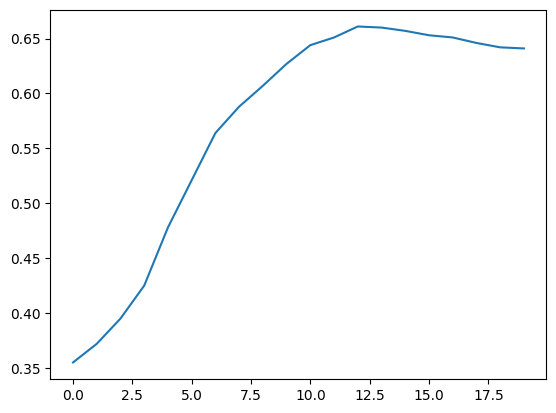

In [21]:
plt.plot(accuracy_history)

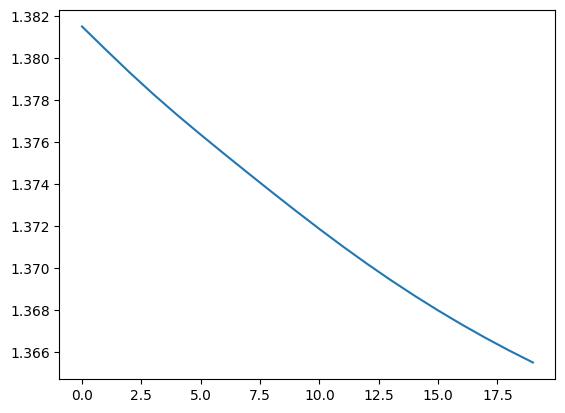

In [22]:
plt.plot(loss_history)

In [23]:
# Simple model test 

features_test = [torch.tensor(f.flatten(), dtype=torch.float32) for f in x_test_scaled]  # Flatten and convert data
targets_test = torch.tensor(y_test, dtype=torch.long)

num_correct = 0

# Evaluation loop
for i in range(1000):
    x_tensor = features_test[i].view(1, -1)
    probs = circuit(x_tensor, *params)
    probs = probs.squeeze()

    # Getting the predicted class index
    predicted_class = torch.argmax(probs).item()

    #print(f"Predicted: {predicted_class}, Actual: {targets_test[i].item()}")

    # Check if the prediction is correct
    if predicted_class == targets_test[i].item():
        num_correct += 1

# Print overall results
print(f"Number of correct predictions: {num_correct} out of 1000")


Number of correct predictions: 621 out of 1000
